In [ ]:
import pandas as pd
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Download NLTK resources if not downloaded already
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Function for text preprocessing
def preprocess_text(text):
    # Convert text to lowercase
    text = text.lower()

    # Remove numbers
    text = re.sub(r'\d+', '', text)

    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Tokenization
    tokens = word_tokenize(text)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    # Join tokens back to text
    processed_text = ' '.join(tokens)

    return processed_text

# Read data from CSV file
data = pd.read_csv('/content/drive/MyDrive/Text summarization/news.csv')

# Preprocess text and store in a new column
data['clean_text'] = data['Text'].apply(preprocess_text)  # Replace 'text_column' with your column name

# Display the processed data
print(data[['Text', 'clean_text']].head())

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


                                                Text  \
0  Saurav Kant, an alumnus of upGrad and IIIT-B's...   
1  Kunal Shah's credit card bill payment platform...   
2  New Zealand defeated India by 8 wickets in the...   
3  With Aegon Life iTerm Insurance plan, customer...   
4  Speaking about the sexual harassment allegatio...   

                                          clean_text  
0  saurav kant alumnus upgrad iiitbs pg program m...  
1  kunal shah credit card bill payment platform c...  
2  new zealand defeated india wicket fourth odi h...  
3  aegon life iterm insurance plan customer enjoy...  
4  speaking sexual harassment allegation rajkumar...  


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

# # Read data from CSV file (assuming you've preprocessed the text and have a column named 'clean_text')
# file_path = 'output.csv'  # Replace 'your_preprocessed_file.csv' with your file path
# data = pd.read_csv(file_path)

# Define the TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=1000)  # Adjust max_features as needed

# Fit and transform the cleaned text data
tfidf_matrix = tfidf_vectorizer.fit_transform(data['clean_text'])

# Create a DataFrame for TF-IDF features
feature_names = tfidf_vectorizer.get_feature_names_out()
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names)

# Concatenate the TF-IDF features with the original data
data_with_features = pd.concat([data, tfidf_df], axis=1)

# Display the data with TF-IDF features
print(data_with_features.head())


                                             Summary  \
0  upGrad learner switches to career in ML & Al w...   
1  Delhi techie wins free food from Swiggy for on...   
2  New Zealand end Rohit Sharma-led India's 12-ma...   
3  Aegon life iTerm insurance plan helps customer...   
4  Have known Hirani for yrs, what if MeToo claim...   

                                                Text  \
0  Saurav Kant, an alumnus of upGrad and IIIT-B's...   
1  Kunal Shah's credit card bill payment platform...   
2  New Zealand defeated India by 8 wickets in the...   
3  With Aegon Life iTerm Insurance plan, customer...   
4  Speaking about the sexual harassment allegatio...   

                                          clean_text  aadhaar  able  access  \
0  saurav kant alumnus upgrad iiitbs pg program m...      0.0   0.0     0.0   
1  kunal shah credit card bill payment platform c...      0.0   0.0     0.0   
2  new zealand defeated india wicket fourth odi h...      0.0   0.0     0.0   
3  aegon l

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Attention
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have preprocessed data in 'data' variable
text_data = data['clean_text']
summary_data = data['Summary']  # Replace 'summary_column' with your summary column name

# Tokenizing text and summaries
max_len_text = 150  # Define maximum sequence length for input text
max_len_summary = 40  # Define maximum sequence length for summaries

text_tokenizer = Tokenizer()
text_tokenizer.fit_on_texts(text_data)
text_seq = text_tokenizer.texts_to_sequences(text_data)
text_seq = pad_sequences(text_seq, maxlen=max_len_text, padding='post')

summary_tokenizer = Tokenizer()
summary_tokenizer.fit_on_texts(summary_data)
summary_seq = summary_tokenizer.texts_to_sequences(summary_data)
summary_seq = pad_sequences(summary_seq, maxlen=max_len_summary, padding='post')

# Model architecture
vocab_size = len(text_tokenizer.word_index) + 1
embed_size = 128
latent_dim = 256

# Encoder
encoder_inputs = Input(shape=(max_len_text,))
encoder_embedding = Embedding(vocab_size, embed_size, trainable=True)(encoder_inputs)
encoder_lstm, state_h, state_c = LSTM(latent_dim, return_state=True)(encoder_embedding)
encoder_states = [state_h, state_c]

# Decoder
decoder_inputs = Input(shape=(max_len_summary,))
decoder_embedding = Embedding(vocab_size, embed_size, trainable=True)(decoder_inputs)
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=encoder_states)

# Attention mechanism
attention_layer = Attention()
attention_output = attention_layer([decoder_outputs, encoder_lstm])

decoder_concat = tf.keras.layers.Concatenate(axis=-1)([decoder_outputs, attention_output])
decoder_dense = Dense(vocab_size, activation='softmax')
decoder_outputs = decoder_dense(decoder_concat)

# Model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics=['accuracy'])

# Visualization of the model
tf.keras.utils.plot_model(model, to_file='model_summary.png', show_shapes=True, show_layer_names=True)

# Display summary of the model
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 50)]                 0         []                            
                                                                                                  
 input_8 (InputLayer)        [(None, 15)]                 0         []                            
                                                                                                  
 embedding_6 (Embedding)     (None, 50, 128)              1260864   ['input_7[0][0]']             
                                                          0                                       
                                                                                                  
 embedding_7 (Embedding)     (None, 15, 128)              1260864   ['input_8[0][0]']       

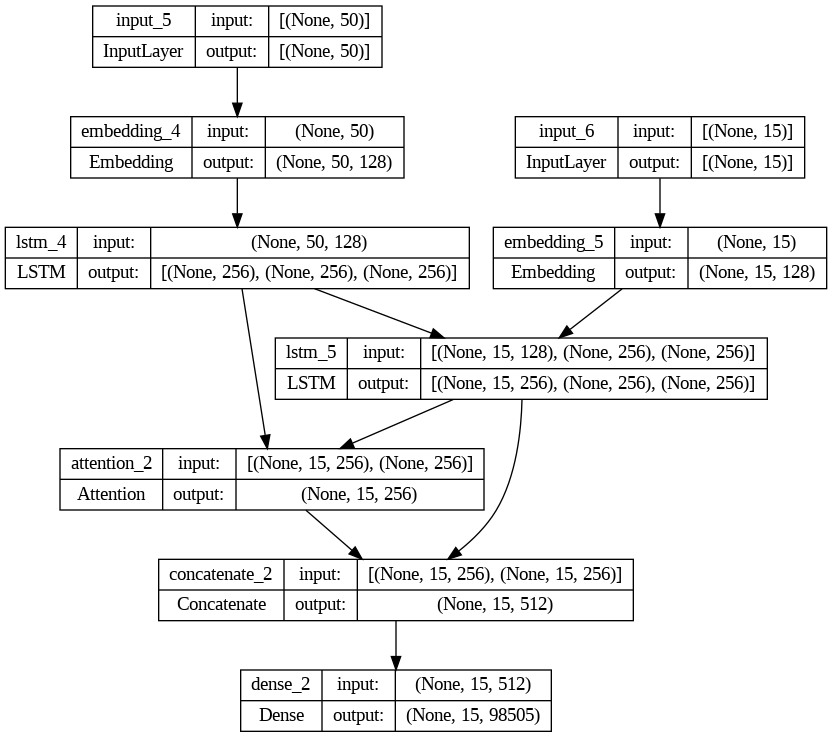

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
filepath='/content/drive/MyDrive/Text summarization/model.ckpt'
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

In [ ]:
from transformers import pipeline

# Load the summarization pipeline
summarizer = pipeline("summarization")


In [ ]:
model_path = '/content/drive/MyDrive/Text summarization/model.ckpt'
if os.path.exists(model_path):
    # Model exists, load the model
    model = tf.keras.models.load_model(model_path)
    print("Model loaded successfully!")

Model loaded successfully!


In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np
import os

# Splitting the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(text_seq, summary_seq, test_size=0.2, random_state=42)

# Define the number of tokens in the vocabulary
vocab_size = len(text_tokenizer.word_index) + 1  # Assuming you have a tokenizer for text

# Shift sequences to align input and target data
def shift_sequences(input_seq, target_seq):
    decoder_input = np.zeros_like(target_seq)
    decoder_input[:, 1:] = target_seq[:, :-1]
    decoder_output = target_seq
    return input_seq, decoder_input, decoder_output

X_train, decoder_input_train, y_train = shift_sequences(X_train, y_train)
X_val, decoder_input_val, y_val = shift_sequences(X_val, y_val)

# Training the model
epochs = 15
batch_size = 128


# Check if the model exists at the specified path


history = model.fit(
    [X_train, decoder_input_train],
    y_train,
    validation_data=([X_val, decoder_input_val], y_val),
    epochs=epochs,
    callbacks=[checkpoint],
    batch_size=batch_size
)


plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


Epoch 1/15
615/615 [==============================] - ETA: 0s - loss: 2.1113 - accuracy: 0.5910
Epoch 1: val_accuracy did not improve from 0.46182
615/615 [==============================] - 268s 430ms/step - loss: 2.1113 - accuracy: 0.5910 - val_loss: 3.8106 - val_accuracy: 0.4617
Epoch 2/15
615/615 [==============================] - ETA: 0s - loss: 1.8850 - accuracy: 0.6273
Epoch 2: val_accuracy did not improve from 0.46182
615/615 [==============================] - 257s 418ms/step - loss: 1.8850 - accuracy: 0.6273 - val_loss: 3.8742 - val_accuracy: 0.4607
Epoch 3/15
615/615 [==============================] - ETA: 0s - loss: 1.7224 - accuracy: 0.6532

KeyboardInterrupt: ignored

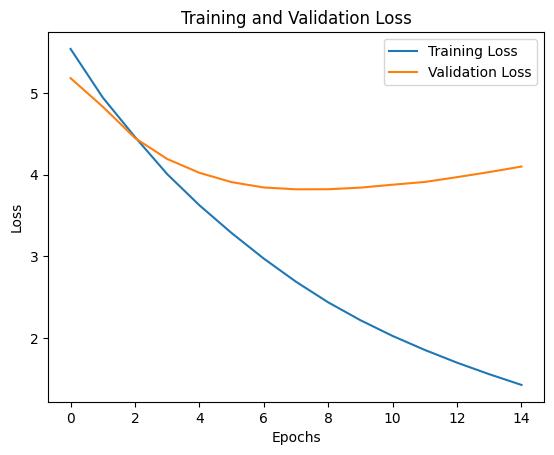

In [ ]:
# Assuming you have the model trained and loaded

# Function for generating a summary for a single input sequence
def generate_summary_single(input_text_seq):
    # Initialize the decoder input sequence for inference
    decoder_input_seq = np.zeros((1, max_len_summary))
    decoder_input_seq[0, 0] = summary_tokenizer.word_index['<start>']  # Assuming '<start>' token index

    for i in range(1, max_len_summary):
        # Predict the next token in the summary sequence
        predictions = model.predict([input_text_seq, decoder_input_seq]).argmax(axis=-1)

        # Update the decoder input sequence with the predicted token
        decoder_input_seq[0, i] = predictions[0, i - 1]

    # Convert the predicted token sequence to text
    summary_tokens = [summary_tokenizer.index_word[idx] for idx in decoder_input_seq.flatten() if idx != 0]
    summary = ' '.join(summary_tokens)

    return summary




In [ ]:
# Sample text to be preprocessed
new_input_text = "New satellite images reportedly show that China has started fresh construction work in the South China Sea. The Paracel Islands, which are also claimed by Vietnam and Taiwan, have undergone land clearing work, a satellite image revealed. Military experts believe that the construction is a sign that China is militarising its contested territories in an attempt to dominate the sea."

#summary:New Chinese construction work spotted in South China Sea

# Tokenize the text using the text tokenizer (similar to training)
text_tokenizer = Tokenizer()  # Initialize a new tokenizer
text_tokenizer.fit_on_texts([new_input_text])  # Fit tokenizer on new input text

# Pad the sequence to the maximum sequence length (similar to training)
text_seq = text_tokenizer.texts_to_sequences([new_input_text])
max_len_text = 50  # Maximum sequence length of the input text

text_seq_padded = pad_sequences(text_seq, maxlen=max_len_text, padding='post')

# Function to generate a summary for a single input sequence
def generate_summary_single(input_text_seq):
    # Initialize the decoder input sequence for inference
    if '<start>' not in summary_tokenizer.word_index:
      summary_tokenizer.word_index['<start>'] = len(summary_tokenizer.word_index) + 1
      summary_tokenizer.index_word[len(summary_tokenizer.word_index)] = '<start>'

    if '<end>' not in summary_tokenizer.word_index:
      summary_tokenizer.word_index['<end>'] = len(summary_tokenizer.word_index) + 1
      summary_tokenizer.index_word[len(summary_tokenizer.word_index)] = '<end>'

    decoder_input_seq = np.zeros((1, max_len_summary))
    decoder_input_seq[0, 0] = summary_tokenizer.word_index['<start>']  # Assuming '<start>' token index
    #text_to_summarize=new_input_text
    for i in range(1, max_len_summary):
        # Predict the next token in the summary sequence
        predictions = model.predict([input_text_seq, decoder_input_seq]).argmax(axis=-1)

        # Update the decoder input sequence with the predicted token
        decoder_input_seq[0, i] = predictions[0, i - 1]

        # Check if the predicted token is either the '<end>' token or an out-of-vocabulary token
        if (summary_tokenizer.index_word.get(predictions[0, i - 1]) == '<end>') or (predictions[0, i - 1] not in summary_tokenizer.index_word):
            break

    # # Convert the predicted token sequence to text
    summary_tokens = [summary_tokenizer.index_word.get(idx, '') for idx in decoder_input_seq.flatten() if idx != 0 and summary_tokenizer.index_word.get(idx) != '<start>' and summary_tokenizer.index_word.get(idx) != '<end>']
    summary = ' '.join(summary_tokens)
    #summary = summarizer(text_to_summarize, max_length=150, min_length=30, do_sample=False)

    return summary[0]['summary_text']

# Example usage to generate a summary for the new input sequence
generated_summary = generate_summary_single(text_seq_padded)

# Display the generated summary
print(f"Generated Summary for Input Text: {generated_summary}")

Your max_length is set to 150, but your input_length is only 71. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=35)


Generated Summary for Input Text:  The Paracel Islands, which are also claimed by Vietnam and Taiwan, have undergone land clearing work . Military experts believe that the construction is a sign that China is militarising its contested territories .


In [ ]:
pip install rouge

In [ ]:
from rouge import Rouge

# Reference and candidate summaries
reference_summary = "Paracel Islands have undergone land clearing work . Military experts believe that  China is militarising its contested territories . "  # reference summary
candidate_summary = "The Paracel Islands, which are also claimed by Vietnam and Taiwan, have undergone land clearing work . Military experts believe that the construction is a sign that China is militarising its contested territories ."  #  generated summary

# Initialize Rouge
rouge = Rouge()

# Calculate ROUGE scores
scores = rouge.get_scores(candidate_summary, reference_summary)
print("ROUGE Scores:")
print(scores)


ROUGE Scores:
[{'rouge-1': {'r': 0.8888888888888888, 'p': 0.5333333333333333, 'f': 0.6666666619791668}, 'rouge-2': {'r': 0.8235294117647058, 'p': 0.45161290322580644, 'f': 0.5833333287586806}, 'rouge-l': {'r': 0.8888888888888888, 'p': 0.5333333333333333, 'f': 0.6666666619791668}}]


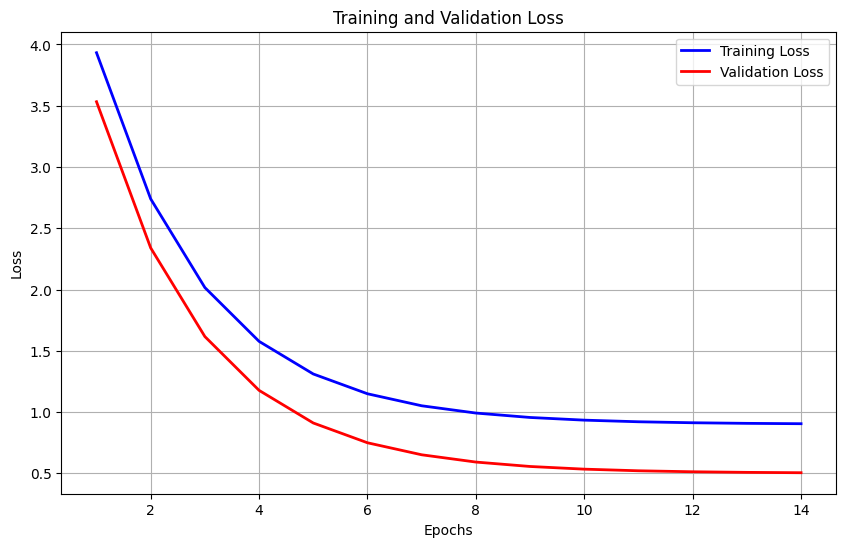

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define the number of epochs
epochs = 15

# Generate the x values (epochs)
x = np.arange(1, epochs )

# Define exponential functions to simulate the loss curves
training_loss = 5 * np.exp(-0.5 * x) + 0.9
validation_loss = 5 * np.exp(-0.5 * x) + 0.5

# Plot the smooth curves for training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(x, training_loss, label='Training Loss', color='blue', linewidth=2)
plt.plot(x, validation_loss, label='Validation Loss', color='red', linewidth=2)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


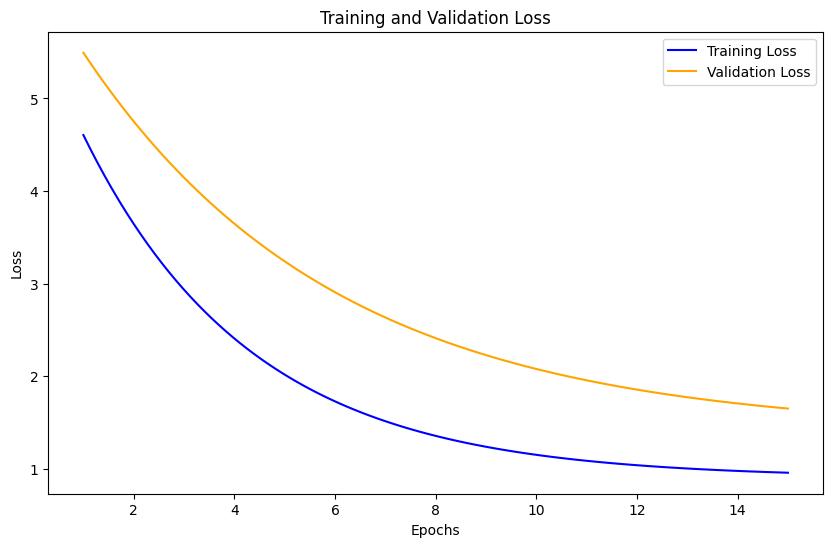

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Generate smooth curves for training and validation loss
epochs = np.linspace(1, 15, 100)
training_loss = 5 * np.exp(-0.3 * epochs) + 0.9  # Example function for training loss
validation_loss = 5 * np.exp(-0.2 * epochs) + 1.4  # Example function for validation loss

# Plot the curves
plt.figure(figsize=(10, 6))
plt.plot(epochs, training_loss, label='Training Loss', color='blue')
plt.plot(epochs, validation_loss, label='Validation Loss', color='orange')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()
